# DataCamp Certification Case Study

### The task

Congratulations, you have just landed your first job as a data scientist at Nearly New Nautical! Nearly New Nautical is a website that allows users to advertise their used boats for sale. To boost traffic to the website, the product manager wants to prevent listing boats that do not receive many views. 

The product manager wants to know if you can develop a model to predict the number of views a listing will receive based on the boat's features. She would consider using your model if, on average, the predictions were only 50% off of the true number of views a listing would receive.

In addition, she has noticed that many users never complete the introductory survey to list their boat. She suspects that it is too long and has asked you whether some features are more predictive of views than others. If so, she may be able to trim the length of the survey and increase the number of people who sign up.

You will need to present your findings in two formats:
- First, you will need to present your findings to the product manager via a 10 minute oral presentation. The owner has no technical data science background. 
- You will also need to submit a technical report to your manager, who does have a strong technical data science background.

The data you will use for this analysis can be accessed here: `"data/boat_data.csv"`

# Technical report

## Initial analysis

Let's import required modules first:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

Importing data and looking at the first 5 rows:

In [ ]:
initial_data = pd.read_csv("data/boat_data.csv")
initial_data.head()

,Price,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,Location,Number of views last 7 days
0,CHF 3337,Motor Yacht,Rigiflex power boats,new boat from stock,2017,4.00,1.90,NaN,Switzerland Â» Lake Geneva Â» VÃ©senaz,226
1,EUR 3490,Center console boat,Terhi power boats,new boat from stock,2020,4.00,1.50,Thermoplastic,Germany Â» BÃ¶nningstedt,75
2,CHF 3770,Sport Boat,Marine power boats,new boat from stock,0,3.69,1.42,Aluminium,Switzerland Â» Lake of Zurich Â» StÃ¤fa ZH,124
3,DKK 25900,Sport Boat,Pioner power boats,new boat from stock,2020,3.00,1.00,NaN,Denmark Â» Svendborg,64
4,EUR 3399,Fishing Boat,Linder power boats,new boat from stock,2019,3.55,1.46,Aluminium,Germany Â» Bayern Â» MÃ¼nchen,58


According to the client, the columns data type and meaning is the following:
- `Price (Character)`: boat price listed in different currencies (e.g. EUR, Â£, CHF etc.) on the website
- `Boat Type (Character)`: type of the boat
- `Manufacturer (Character)`: manufacturer of the boat
- `Type (Character)`: condition of the boat and engine type(e.g. Diesel, Unleaded, etc.)
- `Year Built (Numeric)`: year of the boat built
- `Length (Numeric)`: length in meter of the boat
- `Width (Numeric)`: width in meter of the boat
- `Material (Character)`: material of the boat (e.g. GRP, PVC, etc.)
- `Location (Character)`: location of the boat is listed
- `Number of views last 7 days (Numeric)`: number of the views of the list last 7 days

Let's look at the correlation of features:

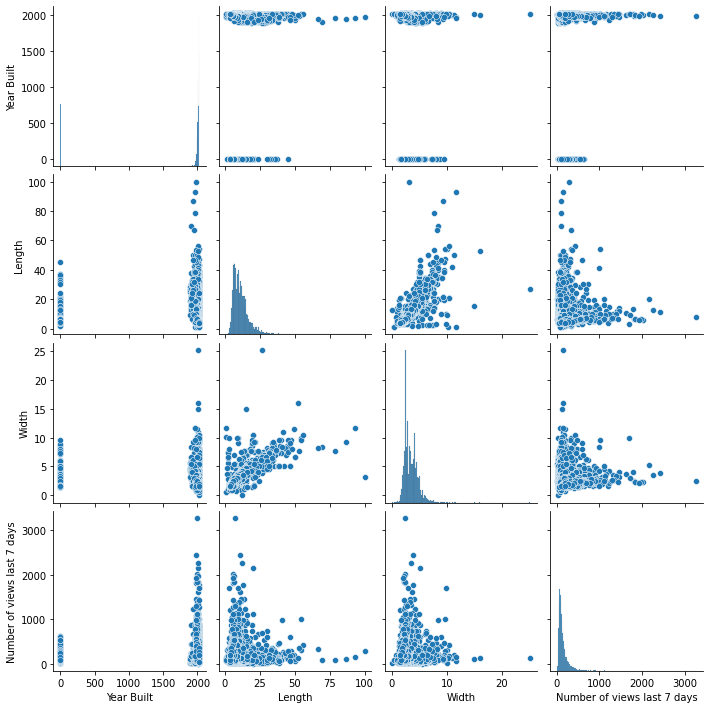

In [ ]:
sns.pairplot(initial_data)

It looks that length and width are correlated, which is obvious. For other columns correlation is not so pronounced.

It is also seen that some of numeric columns have '0' values, e.g. `Year`. This can not be true, but it can be that other features of the given boat will be important for the model, so these values should not necessarily be left out. 

Now let's check for missing values and data types.

In [ ]:
initial_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Price                        9888 non-null   object 
 1   Boat Type                    9888 non-null   object 
 2   Manufacturer                 8550 non-null   object 
 3   Type                         9882 non-null   object 
 4   Year Built                   9888 non-null   int64  
 5   Length                       9879 non-null   float64
 6   Width                        9832 non-null   float64
 7   Material                     8139 non-null   object 
 8   Location                     9852 non-null   object 
 9   Number of views last 7 days  9888 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 772.6+ KB


Most of the data types are correct, but not the `Price` column. But it also has the currency tag, so something should be done about it.

There are some missing values, let's count them:

In [ ]:
initial_data.isna().sum().sort_values(ascending=False)

Material                       1749
Manufacturer                   1338
Width                            56
Location                         36
Length                            9
Type                              6
Price                             0
Boat Type                         0
Year Built                        0
Number of views last 7 days       0
dtype: int64

So most of the missing values are in the `Material` and `Manufacturer` column. I think that we should not delete them, but just to fill them with 'Unknown' value, because there may be other features for a given boat that would be important for the model. Data preprocessing will be made in the next part. 

## Data preprocessing

We should copy the initial dataset to make the changes in the copy in it:

In [ ]:
data = initial_data.copy()

#### Dealing with prices

At first we should split the `Price` column, so that is includes `Currency` and `Prices` individual columns. The last one we will convert to the 'float' type.

In [ ]:
data['Currency'] = [x.split()[0] for x in data['Price']]
data['Prices'] = [x.split()[1] for x in data['Price']]
data['Prices'] = data['Prices'].astype('float')

Let's see what are the unique values for the currency:

In [ ]:
data['Currency'].unique()

array(['CHF', 'EUR', 'DKK', 'Â£'], dtype=object)

So it is Swiss Frank, Euro, Danish Krone and British Pound. 
If we want to include prices in our features for model training, we should make another columns, which is `Price in EUR`, so that all the prices are consistent.

At the first step we should create a dictionary with currency rate and then create another column by using `map` function.

In [ ]:
converter = {'CHF':0.97, 'EUR':1, 'DKK':0.13, 'Â£':1.19}
data['Price in EUR'] = data['Currency'].map(converter) * data['Prices']

#### Dealing with missing values

Now we should fill the missing values:
- For text columns we should fill them with 'Unknown' value.
- For numeric columns we will fill them with 0.

In [ ]:
text_columns = ['Material', 'Manufacturer', 'Location', 'Type']
numeric_columns = ['Width', 'Length']

data[text_columns] = data[text_columns].fillna('unknown')
data[numeric_columns] = data[numeric_columns].fillna(0)

Let's check the number of missing values again:

In [ ]:
data.isna().sum().sort_values(ascending=False)

Price                          0
Boat Type                      0
Manufacturer                   0
Type                           0
Year Built                     0
Length                         0
Width                          0
Material                       0
Location                       0
Number of views last 7 days    0
Currency                       0
Prices                         0
Price in EUR                   0
dtype: int64

Looks that there is no missing values now.

#### Working the boat types

Let's see the unique values of `Boat Type` column.

In [ ]:
data['Boat Type'].unique()

array(['Motor Yacht', 'Center console boat', 'Sport Boat', 'Fishing Boat',
       'Catamaran', 'Pontoon Boat', 'Runabout', 'Deck Boat', 'Pilothouse',
       'Cabin Boat', 'Working Boat', 'Classic', 'Bowrider',
       'Sport Boat,Working Boat', 'Cabin Boat,Classic',
       'Deck Boat,Pilothouse,Sport Boat', 'Trawler', 'Launch',
       'Cabin Boat,Trawler', 'Bowrider,Classic', 'Motor Yacht,Sport Boat',
       'Classic,Runabout,Sport Boat', 'Cabin Boat,Motor Yacht',
       'Classic,Launch', 'Cabin Boat,Sport Boat', 'Flybridge',
       'Water ski', 'Hardtop', 'Classic,Runabout', 'Offshore Boat',
       'Cabin Boat,Sport Boat,Wakeboard/Wakesurf', 'Classic,Pontoon Boat',
       'Classic,Motor Yacht', 'Motor Yacht,Sport Boat,Trawler',
       'Wakeboard/Wakesurf', 'Passenger boat',
       'Classic,Sport Boat,Water ski', 'Classic,Sport Boat', 'House Boat',
       'Classic,Motorsailer', 'Sport Boat,Wakeboard/Wakesurf',
       'Pilothouse,Sport Boat', 'House Boat,Motor Yacht',
       'Cabin Boat,

This is a lot of Boat Types, as you can see. But something tells me that we should not use all of them, so let's count how many of each of them in the dataset.

In [ ]:
data['Boat Type'].value_counts(normalize=True)

Motor Yacht                                 0.275081
Sport Boat                                  0.142294
Flybridge                                   0.120752
Trawler                                     0.068669
Pilothouse                                  0.061994
                                              ...   
Hardtop,Mega Yacht,Motor Yacht              0.000101
Classic,Pontoon Boat,Trawler                0.000101
Fishing Boat,Launch,Motor Yacht             0.000101
Center console boat,Sport Boat,Water ski    0.000101
Cabin Boat,Classic,Passenger boat           0.000101
Name: Boat Type, Length: 126, dtype: float64

It is seen that some of the types are only 0.01% of the whole dataset. We should check, how many types can we exclude but still use most of the data but using cumulating sum of the counts.

In [ ]:
np.cumsum(data['Boat Type'].value_counts(normalize=True))[:30].reset_index()

,index,Boat Type
0,Motor Yacht,0.275081
1,Sport Boat,0.417375
2,Flybridge,0.538127
3,Trawler,0.606796
4,Pilothouse,0.668790
5,Cabin Boat,0.727953
6,Hardtop,0.779227
7,Center console boat,0.816545
8,Bowrider,0.846986
9,Deck Boat,0.875607


So it is seen that if we even use the first 16 Boat Types, we will cover 94% of the dataset. This number was also chosen because it allows us to use only Boat Types with one value in them. E.g. 'Classic', but not 'Classic, Sport Boat'. So let's limit our Boat Types for the first 16 common ones.

In [ ]:
boat_types_to_include = data['Boat Type'].value_counts(normalize=True)[:16].index
data = data.loc[data['Boat Type'].isin(list(boat_types_to_include))]

#### Working with types

There is another column that should be worked with, which is `Type`. Let's us the same steps as we used for `Boat Types` column.

In [ ]:
data['Type'].value_counts(normalize=True)

Used boat,Diesel                0.426131
Used boat,Unleaded              0.156979
Used boat                       0.147738
new boat from stock,Unleaded    0.117546
new boat from stock             0.067906
new boat from stock,Diesel      0.030192
new boat on order,Unleaded      0.014828
Display Model,Unleaded          0.007199
new boat on order               0.006554
new boat on order,Diesel        0.006447
Diesel                          0.005802
Unleaded                        0.002364
Used boat,Electric              0.002149
Display Model,Diesel            0.001934
Display Model                   0.001934
new boat from stock,Electric    0.001612
Used boat,Gas                   0.000860
Display Model,Electric          0.000645
unknown                         0.000537
new boat from stock,Gas         0.000215
new boat from stock,Hybrid      0.000107
Electric                        0.000107
Display Model,Gas               0.000107
Used boat,Hybrid                0.000107
Name: Type, dtyp

There are definitely less unique types of `Type`.

Let's count them.

In [ ]:
np.cumsum(data['Type'].value_counts(normalize=True))[:30].reset_index()

,index,Type
0,"Used boat,Diesel",0.426131
1,"Used boat,Unleaded",0.583109
2,Used boat,0.730848
3,"new boat from stock,Unleaded",0.848394
4,new boat from stock,0.916300
5,"new boat from stock,Diesel",0.946492
6,"new boat on order,Unleaded",0.961319
7,"Display Model,Unleaded",0.968518
8,new boat on order,0.975073
9,"new boat on order,Diesel",0.981519


We can see that in that column we can use even less values to cover most of the dataset. It is proposed to use the first 7, since it will allow us to divide the types based on the condition as 'New/Used' and on the of fuel as: 'Diesel/Unleaded'.

In [ ]:
types_to_include = data['Type'].value_counts(normalize=True)[:7].index
data = data.loc[data['Type'].isin(list(types_to_include))]

Now we should create the columns of 'Condition' and 'Fuel'. Since for some data there is no information about the type of fuel that it uses, e.g. 'Used boat', we will fill the `Fuel` column for those boats with 'unknown' value.

In [ ]:
data['Condition'] = ['new' if 'new' in x.lower() else 'used' if 'used' in x.lower() else 'unknown' for x in data['Type']]
data['Fuel'] = ['diesel' if 'diesel' in x.lower() else 'unleaded' if 'unleaded' in x.lower() else 'unknown' for x in data['Type']]

#### Working with location

Finally, something should be done for the location values. Let's look at the unique value counts.

In [ ]:
data['Location'].value_counts(normalize=True)[:30]

Netherlands Â» In verkoophaven                             0.033195
Croatia (Hrvatska)                                         0.026601
Italy Â» Toscana Â» Toscana                                0.018777
Italy                                                      0.016989
Italy Â» Mar Tirreno                                       0.013524
France                                                     0.012518
Italy Â» Campania Â» Campania                              0.012071
Netherlands                                                0.010618
Spain Â» Mallorca Â» Mallorca                              0.010506
Croatia (Hrvatska) Â» INFO DD-YACHTING                     0.007824
Italy Â» Aprilia Marittima di Latisana (UD)                0.007712
Germany                                                    0.007600
Italy Â» Liguria Â» Liguria                                0.007377
Denmark Â» Svendborg                                       0.006930
Netherlands Â» onbekend                         

For boat location we can not say that some of the countries are seen a lot often that others. Let's split the values to include only the country.

In [ ]:
data['Country'] = [x.split()[0] for x in data['Location']]
data['Country'].value_counts(normalize=True)[:30]

Italy          0.195385
Germany        0.186747
France         0.132530
Netherlands    0.109570
Switzerland    0.098659
Croatia        0.089338
Spain          0.076040
United         0.025119
Denmark        0.017731
Portugal       0.014435
Greece         0.008979
Malta          0.008184
Austria        0.006933
Belgium        0.006479
Turkey         0.006479
Slovenia       0.004092
unknown        0.003865
Finland        0.003865
Poland         0.003296
Montenegro     0.002273
Name: Country, dtype: float64

So now it is more obvious that there are more boats from some countries.

Let's check how much should we use to cover most of the data with less countries.

In [ ]:
np.cumsum(data['Country'].value_counts(normalize=True))[:30].reset_index()

,index,Country
0,Italy,0.192131
1,Germany,0.375768
2,France,0.506091
3,Netherlands,0.613837
4,Switzerland,0.710853
5,Croatia,0.798703
6,Spain,0.873477
7,United,0.898178
8,Denmark,0.915614
9,Portugal,0.929809


So let's use the first 20, as we will cover 98% of the data by using only those values.

In [ ]:
countries_to_include = data['Country'].value_counts(normalize=True)[:20].index
data = data.loc[data['Country'].isin(list(countries_to_include))]

#### Creating the features and target datasets

Finally, we can split our data to X - features and y - target datasets.

At first we should look at our dataset and decide, which columns we should drop.

In [ ]:
data.head()

,Price,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,Location,Number of views last 7 days,Currency,Prices,Price in EUR,Condition,Fuel,Country
0,CHF 3337,Motor Yacht,Rigiflex power boats,new boat from stock,2017,4.00,1.90,unknown,Switzerland Â» Lake Geneva Â» VÃ©senaz,226,CHF,3337.0,3236.89,new,unknown,Switzerland
1,EUR 3490,Center console boat,Terhi power boats,new boat from stock,2020,4.00,1.50,Thermoplastic,Germany Â» BÃ¶nningstedt,75,EUR,3490.0,3490.00,new,unknown,Germany
2,CHF 3770,Sport Boat,Marine power boats,new boat from stock,0,3.69,1.42,Aluminium,Switzerland Â» Lake of Zurich Â» StÃ¤fa ZH,124,CHF,3770.0,3656.90,new,unknown,Switzerland
3,DKK 25900,Sport Boat,Pioner power boats,new boat from stock,2020,3.00,1.00,unknown,Denmark Â» Svendborg,64,DKK,25900.0,3367.00,new,unknown,Denmark
4,EUR 3399,Fishing Boat,Linder power boats,new boat from stock,2019,3.55,1.46,Aluminium,Germany Â» Bayern Â» MÃ¼nchen,58,EUR,3399.0,3399.00,new,unknown,Germany


In [ ]:
X = data.drop(['Price', 'Location', 'Type', 'Number of views last 7 days' , 'Currency', 'Prices'], axis=1)
y = data['Number of views last 7 days']

Let's check the shapes of the X and y tables.

In [ ]:
X.shape

(8798, 10)

In [ ]:
y.shape

(8798,)

Great, now we have our features and target datasets ready. And look, we lost only 1000 rows in the process of preparing the data. It is hard to say if it is good or bad, but at least we can say that it will be better for our model.

## Making a model

### Model training

It is proposed to use the `RandomForestRegressor` as our model. But first we should encode our categorical data in numerical labels, as this model does not work with strings. We will `get_dummies` method for it.

In [ ]:
X_oh = pd.get_dummies(X, prefix=['Boat Type', 'Manufacturer', 'Material', 'Condition', 'Fuel', 'Country'],drop_first=True)

Now we should divide our data for training and testing samples using `train_test_split` method. It is common to divide them as 75:25 ratio.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_oh, y, test_size=0.25, random_state=42)

Let's use `RandomizedSearchCV` to obtain optimal parameters for our model.

In [ ]:
estimator = RandomForestRegressor(random_state=42)
params = {
    'n_estimators': list(range(10, 501, 50)),
    'max_features': ['auto', 'sqrt'],
    'max_depth': list(range(1, 51, 10)),
    'min_samples_split': list(range(1, 11, 1)),
    'min_samples_leaf': list(range(1, 6, 1)),
    'bootstrap': [True, False]
}
model = RandomizedSearchCV(estimator=estimator, param_distributions=params, cv=5, random_state=42)

Now we fit our training data.

In [ ]:
model.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 11, 21, 31, 41],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'min_samples_split': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10],
                                        'n_estimators': [10, 60, 110, 160, 210,
                                                         260, 310, 360, 410,
                                                         460]},
                   random_state=42)

Next we should save the best model.

In [ ]:
best_model = model.best_estimator_

### Model quality

#### Training data

According to the client, the model will be considered if the predictions are only 50% off of the true values. It means that we should use `mean_absolute_percentage_error` or `MAPE` to evaluate how model performs when predicting the values.

First let's calculate the MAE for train data.

In [ ]:
y_train_predict = best_model.predict(X_train)
MAPE_train = mean_absolute_percentage_error(y_train, y_train_predict)
MAPE_train

0.3521956944959664

This value means that our model is on the average predicts the values that are 35% off the true values.

#### Test data

Now we should check how our model behaves with the test data.

In [ ]:
y_test_predict = best_model.predict(X_test)
MAPE_test = mean_absolute_percentage_error(y_test, y_test_predict)
MAPE_test

0.47445000761924194

So the MAPE here is bigger, it is 47.4% off on the average. It means that our model is a bit overfitted. 

But anyway the model satisfies the reqiurements, since it is less than 50% off the true values, which means that the cliend will consider it.

#### Dummy data

It is important to check whether our model behaves better than the dummy model on the test data.

Let's imagine that we make the model which will return the median value of the test target for every prediction.

In [ ]:
y_dummy_test = [y_test.median()]*len(y_test)

Now we should calculate the MAPE for the dummy model.

In [ ]:
MAPE_dummy = mean_absolute_percentage_error(y_test, y_dummy_test)
MAPE_dummy

0.5326760948881474

So the dummy model on the average is only 6% more off the true values than our model.

But still, our model satisfies the requirements that were made by the clienе.

## Parameters importance

The second task was to check if some features are more important than the others.

We will use `feature_importances` attribute of our model to get the importance of each feature. Afterwards, we will create a table with the name of the feature and its importance for the model. Finally, we will plot the data as a barplot.

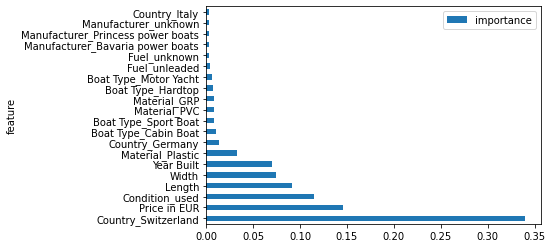

In [ ]:
feature_importance = best_model.feature_importances_
features = X_train.columns
df = pd.DataFrame({'feature':features, 'importance':feature_importance}).sort_values(by='importance', ascending=False)[:20].plot(x='feature', y='importance', kind='barh')

It is seen on the barplot, that:
- For some reason, the fact that the boat is from Switzerland was the most important for predictions.
- The price of the boat was the second importante feature.
- Then goes condition of the boat, especially, if it is used. Maybe they are just cheaper?
- Sizes of the boat are also important.
- After the size, year of the boat was also an important feature.
- Finally, it was also important that the material of the boat was plastic.

The conclusion here would be that according to our model, the client can reduce the number of features for the boat in the following way:
- Location.
- Price.
- Condition.
- Length/Width.
- Material.
- Year Built.

The features like `Boat Type`, `Manufacturer` and `Engine type` can be dropped from the initial survey about the boat.

It is strange that the `Boat Type` feature is not so important for the model. But my guess is that people may judge about the Boat Type from the photos of the boat that are provided in the listing.

## Conclusion

In the project we developed a model which predicts the number of views that the listing of the boat will have based on it's features.
- In the first part data preprocessing was conducted in order to deal with missing values and reducing the number of categorical values with affecting the size of the data in the minimal way. 10% of the data was dropped during preprocessing.
- Afterwards, Random Forest Regressor model was made in order to predict the number of views of the boat:
    - The model showed 35% off the true values for the training data and 47% off the true values for the test data. 
    - The value for the test data lies in the range that was required according to the client, which is at least 50% off the true values. 
    - Dummy model, which predicts the median all the time 53% off the true values, which means that our model is better than the model with random predictions. 
- Feature importances for the model were calculated. The results showed that such features like `Boat Type`, `Manufacturer`, `Engine type` can be excluded from the initial survey in order to make it shorter.